In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as sci
from PyDSTool import *
import scipy.optimize as sco
from scipy import optimize
from scipy.interpolate import interp1d
import mpld3
from tabulate import tabulate

## Parameters and Initial Conditions

In [47]:
y0 = (1, 1, 23.15, 8.18, 1)

In [298]:
# initialize parameters for running the model without optimization
p_A = 22800
p_O = 0.000381
p_C = 3.29
p_R = 0.039
d_A = 0.693
d_O = 0.09625
d_C = 0.173
d_R = 0.279
mu_R = 9.091
K_A = 1.75
K_R = 0.45
T_C = 720
T_d = 20
I_base = 1
C_bar = 4 # from Castro et al., 1994
b = 0.6
k = 1
mu_C = 0.5
q1 = 0.1
n = 5

In [302]:
# set bounds for optimization
bounds = ((20520, 25080), (0.000142, 0.00062), (1.58,5), (0.0008, 0.07), (0.6237, 0.7623), (0.086625, 0.105875), (0.1557, 0.1903), (0.2511, 0.3069), (8.1819, 10.0001), (0.5, 180), (0.2, 0.7), (648, 792), (0, 2.5), (1, 1), (4, 12), (0.54, 0.66), (1, 10), (0, 1), (0, 1), (4, 6))


In [307]:
# length of time over which we wish to integrate
timeLength = (-0.1,1440.1)

# time interval and step definition, based on XPP model from authors
t_start = -0.1
t_end = 1440.1
t_step = 0.1

## Put Raw Data Into Arrays

In [169]:
yehudaControlCortisol = np.genfromtxt("yehuda-control-cortisol.txt")
yehudaPTSDCortisol = np.genfromtxt("yehuda-PTSD-cortisol.txt")
yehudaDepressedCortisol = np.genfromtxt("yehuda-depressed-cortisol.txt")

In [185]:
# extract the data from text files into 145x2 arrays
carrollControlCortisol = np.genfromtxt("controlGroupCortisolCarroll.txt", dtype = float)
carrollHCDepressedCortisol = np.genfromtxt("HCDepressedCortisolCarroll.txt", dtype = float)
carrollLCDepressedCortisol = np.genfromtxt("LCDepressedCortisolCarroll.txt", dtype = float)

carrollControlACTH = np.genfromtxt("controlGroupACTHCarroll.txt", dtype = float)
carrollHCDepressedACTH = np.genfromtxt("HCDepressedACTHCarroll.txt", dtype = float)
carrollLCDepressedACTH = np.genfromtxt("LCDepressedACTHCarroll.txt", dtype = float)

In [186]:
# rearrange Carroll data, so that we can start optimizing at midnight and go until 10AM 34 hours later
carrollControlCortisol_rearr = np.vstack((carrollControlCortisol[60:,:], carrollControlCortisol[0:60,:]))
carrollHCDepressedCortisol_rearr = np.vstack((carrollHCDepressedCortisol[60:,:], carrollHCDepressedCortisol[0:60,:]))
carrollLCDepressedCortisol_rearr = np.vstack((carrollLCDepressedCortisol[60:,:], carrollLCDepressedCortisol[0:60,:]))

carrollControlACTH_rearr = np.vstack((carrollControlACTH[60:,:], carrollControlACTH[0:60,:]))
carrollHCDepressedACTH_rearr = np.vstack((carrollHCDepressedACTH[60:,:], carrollHCDepressedACTH[0:60,:]))
carrollLCDepressedACTH_rearr = np.vstack((carrollLCDepressedACTH[60:,:], carrollLCDepressedACTH[0:60,:]))

In [230]:
golierPTSDCortisol = np.genfromtxt("golier-PTSD-cortisol.txt", dtype = float)
golierNonPTSDTraumaExposedCortisol = np.genfromtxt("golier-non-PTSD-trauma-exposed-cortisol.txt", dtype = float)
golierNonPTSDNonExposedCortisol = np.genfromtxt("golier-non-exposed-control-cortisol.txt", dtype = float)

golierPTSDACTH = np.genfromtxt("golier-PTSD-ACTH.txt", dtype = float)
golierNonPTSDTraumaExposedACTH = np.genfromtxt("golier-non-PTSD-trauma-exposed-ACTH.txt", dtype = float)
golierNonPTSDNonExposedACTH = np.genfromtxt("golier-non-exposed-control-ACTH.txt", dtype = float)

In [231]:
golierPTSDCortisol_rearr = np.vstack((golierPTSDCortisol[7:,:], golierPTSDCortisol[0:7,:]))
golierNonPTSDTraumaExposedCortisol_rearr = np.vstack((golierNonPTSDTraumaExposedCortisol[7:,:], golierNonPTSDTraumaExposedCortisol[0:7,:]))
golierNonPTSDNonExposedCortisol_rearr = np.vstack((golierNonPTSDNonExposedCortisol[7:,:], golierNonPTSDNonExposedCortisol[0:7,:]))

golierPTSDACTH_rearr = np.vstack((golierPTSDACTH[3:,:], golierPTSDACTH[0:3,:]))
golierNonPTSDTraumaExposedACTH_rearr = np.vstack((golierNonPTSDTraumaExposedACTH[3:,:], golierNonPTSDTraumaExposedACTH[0:3,:]))
golierNonPTSDNonExposedACTH_rearr = np.vstack((golierNonPTSDNonExposedACTH[3:,:], golierNonPTSDNonExposedACTH[0:3,:]))

In [232]:
bremnerAbusedPTSDCortisol = np.genfromtxt("bremner-abused-PTSD-cortisol.txt", dtype = float)
bremnerNonAbusedPTSDCortisol = np.genfromtxt("bremner-non-abused-PTSD-cortisol.txt", dtype = float)
bremnerNonAbusedNonPTSDCortisol = np.genfromtxt("bremner-non-abused-non-PTSD-cortisol.txt", dtype = float)

In [233]:
bremnerAbusedPTSDCortisol_rearr = np.vstack((bremnerAbusedPTSDCortisol[68:,:],bremnerAbusedPTSDCortisol[0:68,:]))
bremnerNonAbusedPTSDCortisol_rearr = np.vstack((bremnerNonAbusedPTSDCortisol[68:,:],bremnerNonAbusedPTSDCortisol[0:68,:]))
bremnerNonAbusedNonPTSDCortisol_rearr = np.vstack((bremnerNonAbusedNonPTSDCortisol[68:,:],bremnerNonAbusedNonPTSDCortisol[0:68,:]))

### Smooth Data, If Desired

In [162]:
# this function computes the moving average over the neighboring 5 points
def smoothing(a, n=5) :
    idx = int((n-1)/2)
    ret = np.cumsum(a, dtype=float)
    ret[idx+1:-idx] = ret[n:] - ret[:-n]
    ret[idx] = ret[idx+2]
    return ret[idx:-idx] / n

In [163]:
yehudaControlCortisol_smooth = yehudaControlCortisol
yehudaPTSDCortisol_smooth = yehudaPTSDCortisol
yehudaDepressedCortisol_smooth = yehudaDepressedCortisol

yehudaControlCortisol_smooth[2:-2,1] = smoothing(yehudaControlCortisol[:,1])
yehudaPTSDCortisol_smooth[2:-2,1] = smoothing(yehudaPTSDCortisol[:,1])
yehudaDepressedCortisol_smooth[2:-2,1] = smoothing(yehudaDepressedCortisol[:,1])

In [164]:
# run smoothing if so desired
# REMEMBER: need to re-extract the data from the files into the non-smooth arrays to make them non-smooth.
#     I'm still not sure why it's smoothing the original data when I only save the values from the smoothing function
#     into the smooth arrays
carrollControlCortisol_smooth = carrollControlCortisol
carrollHCDepressedCortisol_smooth = carrollHCDepressedCortisol
carrollLCDepressedCortisol_smooth = carrollLCDepressedCortisol

carrollControlACTH_smooth = carrollControlACTH
carrollHCDepressedACTH_smooth = carrollHCDepressedACTH
carrollLCDepressedACTH_smooth = carrollLCDepressedACTH

carrollControlCortisol_rearr_smooth = carrollControlCortisol_rearr
carrollHCDepressedCortisol_rearr_smooth = carrollHCDepressedCortisol_rearr
carrollLCDepressedCortisol_rearr_smooth = carrollLCDepressedCortisol_rearr

carrollControlACTH_rearr_smooth = carrollControlACTH_rearr
carrollHCDepressedACTH_rearr_smooth = carrollHCDepressedACTH_rearr
carrollLCDepressedACTH_rearr_smooth = carrollLCDepressedACTH_rearr

carrollControlCortisol_smooth[2:-2,1] = smoothing(carrollControlCortisol[:,1])
carrollHCDepressedCortisol_smooth[2:-2,1] = smoothing(carrollHCDepressedCortisol[:,1])
carrollLCDepressedCortisol_smooth[2:-2,1] = smoothing(carrollLCDepressedCortisol[:,1])

carrollControlACTH_smooth[2:-2,1] = smoothing(carrollControlACTH[:,1])
carrollHCDepressedACTH_smooth[2:-2,1] = smoothing(carrollHCDepressedACTH[:,1])
carrollLCDepressedACTH_smooth[2:-2,1] = smoothing(carrollLCDepressedACTH[:,1])

carrollControlCortisol_rearr_smooth[2:-2,1] = smoothing(carrollControlCortisol_rearr[:,1])
carrollHCDepressedCortisol_rearr_smooth[2:-2,1] = smoothing(carrollHCDepressedCortisol_rearr[:,1])
carrollLCDepressedCortisol_rearr_smooth[2:-2,1] = smoothing(carrollLCDepressedCortisol_rearr[:,1])

carrollControlACTH_rearr_smooth[2:-2,1] = smoothing(carrollControlACTH_rearr[:,1])
carrollHCDepressedACTH_rearr_smooth[2:-2,1] = smoothing(carrollHCDepressedACTH_rearr[:,1])
carrollLCDepressedACTH_rearr_smooth[2:-2,1] = smoothing(carrollLCDepressedACTH_rearr[:,1])

In [226]:
golierPTSDCortisol_smooth = golierPTSDCortisol
golierNonPTSDTraumaExposedCortisol_smooth = golierNonPTSDTraumaExposedCortisol
golierNonPTSDNonExposedCortisol_smooth = golierNonPTSDNonExposedCortisol
golierPTSDACTH_smooth = golierPTSDACTH
golierNonPTSDTraumaExposedACTH_smooth = golierNonPTSDTraumaExposedACTH
golierNonPTSDNonExposedACTH_smooth = golierNonPTSDNonExposedACTH

golierPTSDCortisol_smooth[2:-2,1] = smoothing(golierPTSDCortisol[:,1])
golierNonPTSDTraumaExposedCortisol_smooth[2:-2,1] = smoothing(golierNonPTSDTraumaExposedCortisol[:,1])
golierNonPTSDNonExposedCortisol_smooth[2:-2,1] = smoothing(golierNonPTSDNonExposedCortisol[:,1])

golierPTSDACTH_smooth[2:-2,1] = smoothing(golierPTSDACTH[:,1])
golierNonPTSDTraumaExposedACTH_smooth[2:-2,1] = smoothing(golierNonPTSDTraumaExposedACTH[:,1])
golierNonPTSDNonExposedACTH_smooth[2:-2,1] = smoothing(golierNonPTSDNonExposedACTH[:,1])

In [227]:
golierPTSDCortisol_rearr_smooth = golierPTSDCortisol_rearr
golierNonPTSDTraumaExposedCortisol_rearr_smooth = golierNonPTSDTraumaExposedCortisol_rearr
golierNonPTSDNonExposedCortisol_rearr_smooth = golierNonPTSDNonExposedCortisol_rearr
golierPTSDACTH_rearr_smooth = golierPTSDACTH_rearr
golierNonPTSDTraumaExposedACTH_rearr_smooth = golierNonPTSDTraumaExposedACTH_rearr
golierNonPTSDNonExposedACTH_rearr_smooth = golierNonPTSDNonExposedACTH_rearr

golierPTSDCortisol_rearr_smooth[2:-2,1] = smoothing(golierPTSDCortisol_rearr[:,1])
golierNonPTSDTraumaExposedCortisol_rearr_smooth[2:-2,1] = smoothing(golierNonPTSDTraumaExposedCortisol_rearr[:,1])
golierNonPTSDNonExposedCortisol_rearr_smooth[2:-2,1] = smoothing(golierNonPTSDNonExposedCortisol_rearr[:,1])

golierPTSDACTH_rearr_smooth[2:-2,1] = smoothing(golierPTSDACTH_rearr[:,1])
golierNonPTSDTraumaExposedACTH_rearr_smooth[2:-2,1] = smoothing(golierNonPTSDTraumaExposedACTH_rearr[:,1])
golierNonPTSDNonExposedACTH_rearr_smooth[2:-2,1] = smoothing(golierNonPTSDNonExposedACTH_rearr[:,1])

In [228]:
bremnerAbusedPTSDCortisol_rearr_smooth = bremnerAbusedPTSDCortisol_rearr
bremnerNonAbusedPTSDCortisol_rearr_smooth = bremnerNonAbusedPTSDCortisol_rearr
bremnerNonAbusedNonPTSDCortisol_rearr_smooth = bremnerNonAbusedNonPTSDCortisol_rearr

bremnerAbusedPTSDCortisol_rearr_smooth[2:-2,1] = smoothing(bremnerAbusedPTSDCortisol_rearr[:,1])
bremnerNonAbusedPTSDCortisol_rearr_smooth[2:-2,1] = smoothing(bremnerNonAbusedPTSDCortisol_rearr[:,1])
bremnerNonAbusedNonPTSDCortisol_rearr_smooth[2:-2,1] = smoothing(bremnerNonAbusedNonPTSDCortisol_rearr[:,1])

In [229]:
bremnerAbusedPTSDCortisol_smooth = bremnerAbusedPTSDCortisol
bremnerNonAbusedPTSDCortisol_smooth = bremnerNonAbusedPTSDCortisol
bremnerNonAbusedNonPTSDCortisol_smooth = bremnerNonAbusedNonPTSDCortisol

bremnerAbusedPTSDCortisol_smooth[2:-2,1] = smoothing(bremnerAbusedPTSDCortisol[:,1])
bremnerNonAbusedPTSDCortisol_smooth[2:-2,1] = smoothing(bremnerNonAbusedPTSDCortisol[:,1])
bremnerNonAbusedNonPTSDCortisol_smooth[2:-2,1] = smoothing(bremnerNonAbusedNonPTSDCortisol[:,1])

In [235]:
#for i in range(len(carrollControlCortisol[:,0])):
#    carrollControlCortisol[:,0] = carrollControlCortisol[:,0]*60
#    carrollControlCortisol_smooth[:,0] = carrollControlCortisol_smooth[:,0]*60
#    carrollControlCortisol_rearr[:,0] = carrollControlCortisol_rearr[:,0]*60
#    carrollControlCortisol_rearr_smooth[:,0] = carrollControlCortisol_rearr_smooth[:,0]*60
#    
#    carrollHCDepressedCortisol[:,0] = carrollHCDepressedCortisol[:,0]*60
#    carrollHCDepressedCortisol_smooth[:,0] = carrollHCDepressedCortisol_smooth[:,0]*60
#    carrollHCDepressedCortisol_rearr[:,0] = carrollHCDepressedCortisol_rearr[:,0]*60
#    carrollHCDepressedCortisol_rearr_smooth[:,0] = carrollHCDepressedCortisol_rearr_smooth[:,0]*60
#    
#    carrollLCDepressedCortisol[:,0] = carrollLCDepressedCortisol[:,0]*60
#    carrollLCDepressedCortisol_smooth[:,0] = carrollLCDepressedCortisol_smooth[:,0]*60
#    carrollLCDepressedCortisol_rearr[:,0] = carrollLCDepressedCortisol_rearr[:,0]*60
#    carrollLCDepressedCortisol_rearr_smooth[:,0] = carrollLCDepressedCortisol_rearr_smooth[:,0]*60
#    
#for i in range(len(carrollControlACTH[:,0])):
#    carrollControlACTH[:,0] = carrollControlACTH[:,0]*60
#    carrollControlACTH_smooth[:,0] = carrollControlACTH_smooth[:,0]*60
#    carrollControlACTH_rearr[:,0] = carrollControlACTH_rearr[:,0]*60
#    carrollControlACTH_rearr_smooth[:,0] = carrollControlACTH_rearr_smooth[:,0]*60
#    
#    carrollHCDepressedACTH[:,0] = carrollHCDepressedACTH[:,0]*60
#    carrollHCDepressedACTH_smooth[:,0] = carrollHCDepressedACTH_smooth[:,0]*60
#    carrollHCDepressedACTH_rearr[:,0] = carrollHCDepressedACTH_rearr[:,0]*60
#    carrollHCDepressedACTH_rearr_smooth[:,0] = carrollHCDepressedACTH_rearr_smooth[:,0]*60
#    
#    carrollLCDepressedACTH[:,0] = carrollLCDepressedACTH[:,0]*60
#    carrollLCDepressedACTH_smooth[:,0] = carrollLCDepressedACTH_smooth[:,0]*60
#    carrollLCDepressedACTH_rearr[:,0] = carrollLCDepressedACTH_rearr[:,0]*60
#    carrollLCDepressedACTH_rearr_smooth[:,0] = carrollLCDepressedACTH_rearr_smooth[:,0]*60
    
golierPTSDCortisol[:,0] = golierPTSDCortisol[:,0]*60
golierPTSDCortisol_smooth[:,0] = golierPTSDCortisol[:,0]
golierPTSDCortisol_rearr[:,0] = golierPTSDCortisol[:,0]
golierPTSDCortisol_rearr_smooth[:,0] = golierPTSDCortisol[:,0]
    
golierNonPTSDTraumaExposedCortisol[:,0] = golierNonPTSDTraumaExposedCortisol[:,0]*60
golierNonPTSDTraumaExposedCortisol_smooth[:,0] = golierNonPTSDTraumaExposedCortisol[:,0]
golierNonPTSDTraumaExposedCortisol_rearr[:,0] = golierNonPTSDTraumaExposedCortisol[:,0]
golierNonPTSDTraumaExposedCortisol_rearr_smooth[:,0] = golierNonPTSDTraumaExposedCortisol[:,0]

golierNonPTSDNonExposedCortisol[:,0] = golierNonPTSDNonExposedCortisol[:,0]*60
golierNonPTSDNonExposedCortisol_smooth[:,0] = golierNonPTSDNonExposedCortisol[:,0]
golierNonPTSDNonExposedCortisol_rearr[:,0] = golierNonPTSDNonExposedCortisol[:,0]
golierNonPTSDNonExposedCortisol_rearr_smooth[:,0] = golierNonPTSDNonExposedCortisol[:,0]
    
golierPTSDACTH[:,0] = golierPTSDACTH[:,0]*60
golierPTSDACTH_smooth[:,0] = golierPTSDACTH[:,0]
golierPTSDACTH_rearr[:,0] = golierPTSDACTH[:,0]
golierPTSDACTH_rearr_smooth[:,0] = golierPTSDACTH[:,0]

golierNonPTSDTraumaExposedACTH[:,0] = golierNonPTSDTraumaExposedACTH[:,0]*60
golierNonPTSDTraumaExposedACTH_smooth[:,0] = golierNonPTSDTraumaExposedACTH[:,0]
golierNonPTSDTraumaExposedACTH_rearr[:,0] = golierNonPTSDTraumaExposedACTH[:,0]
golierNonPTSDTraumaExposedACTH_rearr_smooth[:,0] = golierNonPTSDTraumaExposedACTH[:,0]

golierNonPTSDNonExposedACTH[:,0] = golierNonPTSDNonExposedACTH[:,0]*60
golierNonPTSDNonExposedACTH_smooth[:,0] = golierNonPTSDNonExposedACTH[:,0]
golierNonPTSDNonExposedACTH_rearr[:,0] = golierNonPTSDNonExposedACTH[:,0]
golierNonPTSDNonExposedACTH_rearr_smooth[:,0] = golierNonPTSDNonExposedACTH[:,0]
    
bremnerAbusedPTSDCortisol[:,0] = bremnerAbusedPTSDCortisol[:,0]*60
bremnerAbusedPTSDCortisol_smooth[:,0] = bremnerAbusedPTSDCortisol[:,0]
bremnerAbusedPTSDCortisol_rearr[:,0] = bremnerAbusedPTSDCortisol[:,0]
bremnerAbusedPTSDCortisol_rearr_smooth[:,0] = bremnerAbusedPTSDCortisol[:,0]

bremnerNonAbusedPTSDCortisol[:,0] = bremnerNonAbusedPTSDCortisol[:,0]*60
bremnerNonAbusedPTSDCortisol_smooth[:,0] = bremnerNonAbusedPTSDCortisol[:,0]
bremnerNonAbusedPTSDCortisol_rearr[:,0] = bremnerNonAbusedPTSDCortisol[:,0]
bremnerNonAbusedPTSDCortisol_rearr_smooth[:,0] = bremnerNonAbusedPTSDCortisol[:,0]

bremnerNonAbusedNonPTSDCortisol[:,0] = bremnerNonAbusedNonPTSDCortisol[:,0]*60
bremnerNonAbusedNonPTSDCortisol_smooth[:,0] = bremnerNonAbusedNonPTSDCortisol[:,0]
bremnerNonAbusedNonPTSDCortisol_rearr[:,0] = bremnerNonAbusedNonPTSDCortisol[:,0]
bremnerNonAbusedNonPTSDCortisol_rearr_smooth[:,0] = bremnerNonAbusedNonPTSDCortisol[:,0]

### Plot Data Sets

In [199]:
# make time scale in hours for graphing
j = 0
k = 0
l = 0

timeCarroll = np.zeros(len(carrollControlCortisol[:,0]))
for i in carrollControlCortisol[:,0]:
    timeCarroll[l] = i
    l += 1

In [188]:
for i in range(len(carrollControlCortisol_rearr_smooth)):
    carrollControlACTH[i,0] = timeCarroll[i]
    carrollControlACTH_rearr[i,0] = timeCarroll[i]
    carrollControlACTH_rearr_smooth[i,0] = timeCarroll[i]
    carrollControlACTH_smooth[i,0] = timeCarroll[i]
    
    carrollControlCortisol[i,0] = timeCarroll[i]
    carrollControlCortisol_rearr[i,0] = timeCarroll[i]
    carrollControlCortisol_rearr_smooth[i,0] = timeCarroll[i]
    carrollControlCortisol_smooth[i,0] = timeCarroll[i]
    
    carrollHCDepressedACTH[i,0] = timeCarroll[i]
    carrollHCDepressedACTH_rearr[i,0] = timeCarroll[i]
    carrollHCDepressedACTH_rearr_smooth[i,0] = timeCarroll[i]
    carrollHCDepressedACTH_smooth[i,0] = timeCarroll[i]
    
    carrollLCDepressedACTH[i,0] = timeCarroll[i]
    carrollLCDepressedACTH_rearr[i,0] = timeCarroll[i]
    carrollLCDepressedACTH_rearr_smooth[i,0] = timeCarroll[i]
    carrollLCDepressedACTH_smooth[i,0] = timeCarroll[i]
    
    carrollHCDepressedCortisol[i,0] = timeCarroll[i]
    carrollHCDepressedCortisol_rearr[i,0] = timeCarroll[i]
    carrollHCDepressedCortisol_rearr_smooth[i,0] = timeCarroll[i]
    carrollHCDepressedCortisol_smooth[i,0] = timeCarroll[i]
    
    carrollLCDepressedCortisol[i,0] = timeCarroll[i]
    carrollLCDepressedCortisol_rearr[i,0] = timeCarroll[i]
    carrollLCDepressedCortisol_rearr_smooth[i,0] = timeCarroll[i]
    carrollLCDepressedCortisol_smooth[i,0] = timeCarroll[i]

In [179]:
for i in range(len(golierPTSDCortisol[:,0])):
    golierPTSDCortisol_rearr[i,0] = golierPTSDCortisol[i,0]
    golierPTSDCortisol_rearr_smooth[i,0] = golierPTSDCortisol[i,0]
    golierNonPTSDTraumaExposedCortisol_rearr[i,0] = golierNonPTSDTraumaExposedCortisol[i,0]
    golierNonPTSDTraumaExposedCortisol_rearr_smooth[i,0] = golierNonPTSDTraumaExposedCortisol[i,0]
    golierNonPTSDNonExposedCortisol_rearr[i,0] = golierNonPTSDNonExposedCortisol[i,0]
    golierNonPTSDNonExposedCortisol_rearr_smooth[i,0] = golierNonPTSDNonExposedCortisol[i,0]
    
for i in range(len(golierPTSDACTH[:,0])):
    golierPTSDACTH_rearr[i,0] = golierPTSDACTH[i,0]
    golierPTSDACTH_rearr_smooth[i,0] = golierPTSDACTH[i,0]
    golierNonPTSDTraumaExposedACTH_rearr[i,0] = golierNonPTSDTraumaExposedACTH[i,0]
    golierNonPTSDTraumaExposedACTH_rearr_smooth[i,0] = golierNonPTSDTraumaExposedACTH[i,0]
    golierNonPTSDNonExposedACTH_rearr[i,0] = golierNonPTSDNonExposedACTH[i,0]
    golierNonPTSDNonExposedACTH_rearr_smooth[i,0] = golierNonPTSDNonExposedACTH[i,0]

In [180]:
for i in range(len(bremnerAbusedPTSDCortisol[:,0])):
    bremnerAbusedPTSDCortisol_rearr[i,0] = bremnerAbusedPTSDCortisol[i,0]
    bremnerAbusedPTSDCortisol_rearr_smooth[i,0] = bremnerAbusedPTSDCortisol[i,0]
    bremnerNonAbusedPTSDCortisol_rearr[i,0] = bremnerNonAbusedPTSDCortisol[i,0]
    bremnerNonAbusedPTSDCortisol_rearr_smooth[i,0] = bremnerNonAbusedPTSDCortisol[i,0]
    bremnerNonAbusedNonPTSDCortisol_rearr[i,0] = bremnerNonAbusedNonPTSDCortisol[i,0]
    bremnerNonAbusedNonPTSDCortisol_rearr_smooth[i,0] = bremnerNonAbusedNonPTSDCortisol[i,0]

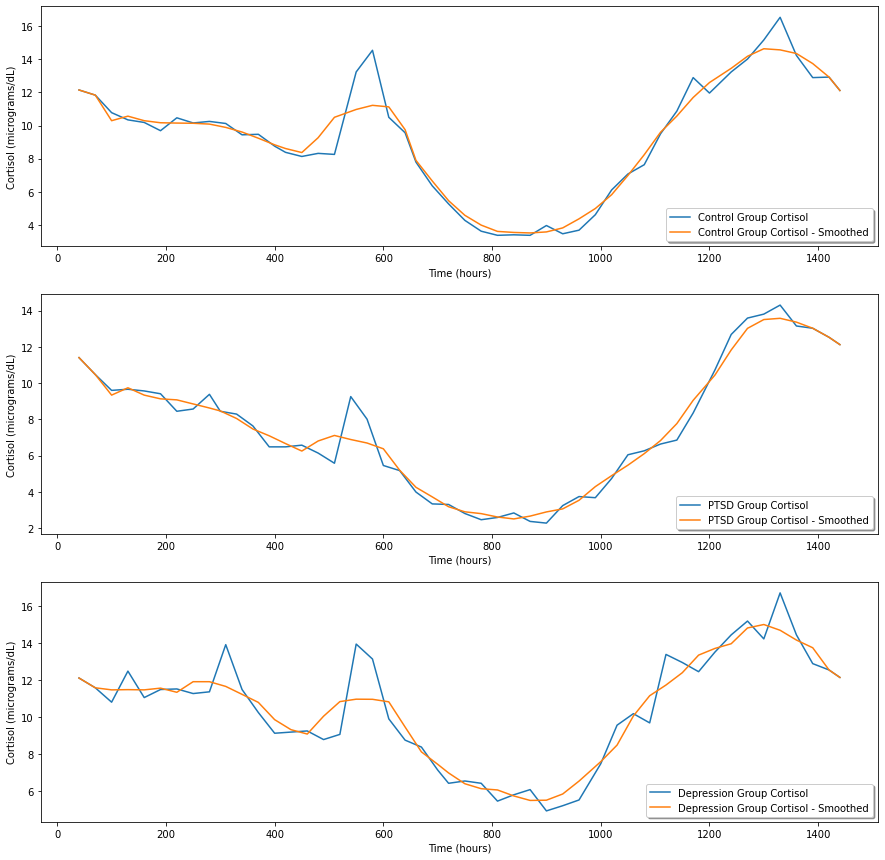

In [259]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (15,15))

ax1.plot(yehudaControlCortisol[:,0], yehudaControlCortisol[:,1], label = "Control Group Cortisol")
ax1.plot(yehudaControlCortisol_smooth[:,0], yehudaControlCortisol_smooth[:,1], label = "Control Group Cortisol - Smoothed")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(yehudaPTSDCortisol[:,0], yehudaPTSDCortisol[:,1], label = "PTSD Group Cortisol")
ax2.plot(yehudaPTSDCortisol_smooth[:,0], yehudaPTSDCortisol_smooth[:,1], label = "PTSD Group Cortisol - Smoothed")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(yehudaDepressedCortisol[:,0], yehudaDepressedCortisol[:,1], label = "Depression Group Cortisol")
ax3.plot(yehudaDepressedCortisol_smooth[:,0], yehudaDepressedCortisol_smooth[:,1], label = "Depression Group Cortisol - Smoothed")
ax3.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax3.legend(loc="lower right", shadow = True, fancybox = True)


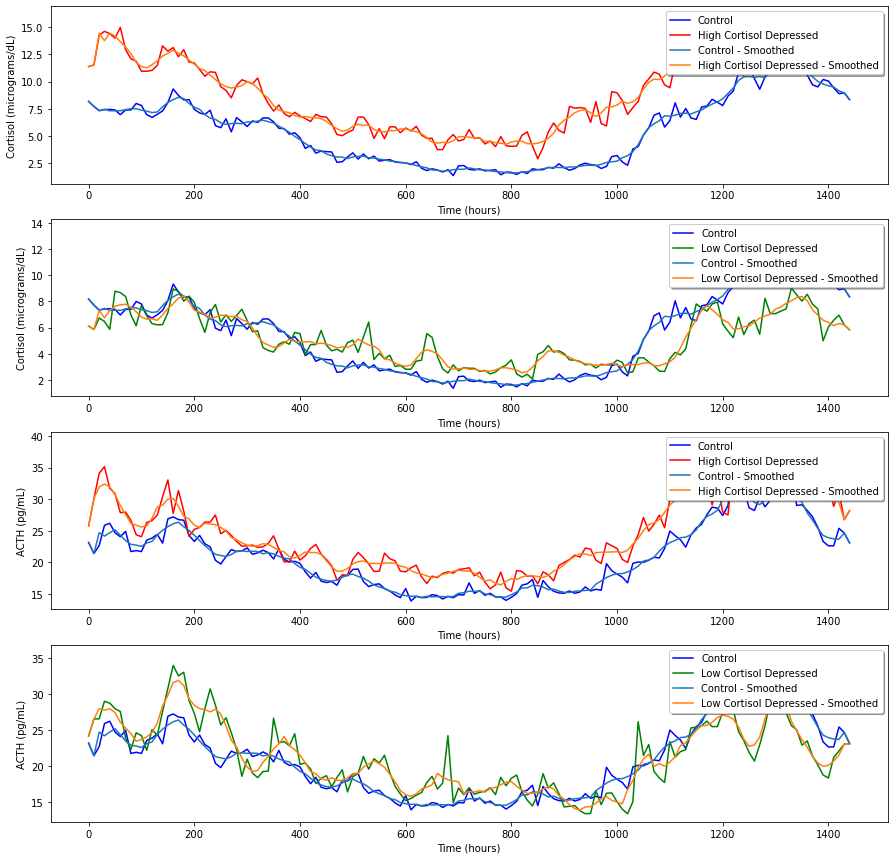

In [260]:
#mpld3.enable_notebook()
%matplotlib inline

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, figsize = (15,15))

ax1.plot(carrollControlCortisol_rearr[:,0], carrollControlCortisol_rearr[:,1], 'b', label = "Control")
ax1.plot(carrollHCDepressedCortisol_rearr[:,0], carrollHCDepressedCortisol_rearr[:,1], 'r', label = "High Cortisol Depressed")
ax1.plot(carrollControlCortisol_rearr_smooth[:,0], carrollControlCortisol_rearr_smooth[:,1], label = "Control - Smoothed")
ax1.plot(carrollHCDepressedCortisol_rearr_smooth[:,0], carrollHCDepressedCortisol_rearr_smooth[:,1], label = "High Cortisol Depressed - Smoothed")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax1.legend(loc="upper right", shadow = True, fancybox = True)

ax2.plot(carrollControlCortisol_rearr[:,0], carrollControlCortisol_rearr[:,1], 'b', label = "Control")
ax2.plot(carrollLCDepressedCortisol_rearr[:,0], carrollLCDepressedCortisol_rearr[:,1], 'g', label = "Low Cortisol Depressed")
ax2.plot(carrollControlCortisol_rearr_smooth[:,0], carrollControlCortisol_rearr_smooth[:,1], label = "Control - Smoothed")
ax2.plot(carrollLCDepressedCortisol_rearr_smooth[:,0], carrollLCDepressedCortisol_rearr_smooth[:,1], label = "Low Cortisol Depressed - Smoothed")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax2.legend(loc="upper right", shadow = True, fancybox = True)

ax3.plot(carrollControlACTH_rearr[:,0], carrollControlACTH_rearr[:,1], 'b', label = "Control")
ax3.plot(carrollHCDepressedACTH_rearr[:,0], carrollHCDepressedACTH_rearr[:,1], 'r', label = "High Cortisol Depressed")
ax3.plot(carrollControlACTH_rearr_smooth[:,0], carrollControlACTH_rearr_smooth[:,1], label = "Control - Smoothed")
ax3.plot(carrollHCDepressedACTH_rearr_smooth[:,0], carrollHCDepressedACTH_rearr_smooth[:,1], label = "High Cortisol Depressed - Smoothed")
ax3.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax3.legend(loc="upper right", shadow = True, fancybox = True)

ax4.plot(carrollControlACTH_rearr[:,0], carrollControlACTH_rearr[:,1], 'b', label = "Control")
ax4.plot(carrollLCDepressedACTH_rearr[:,0], carrollLCDepressedACTH_rearr[:,1], 'g', label = "Low Cortisol Depressed")
ax4.plot(carrollControlACTH_rearr_smooth[:,0], carrollControlACTH_rearr_smooth[:,1], label = "Control - Smoothed")
ax4.plot(carrollLCDepressedACTH_rearr_smooth[:,0], carrollLCDepressedACTH_rearr_smooth[:,1], label = "Low Cortisol Depressed - Smoothed")
ax4.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax4.legend(loc="upper right", shadow = True, fancybox = True)

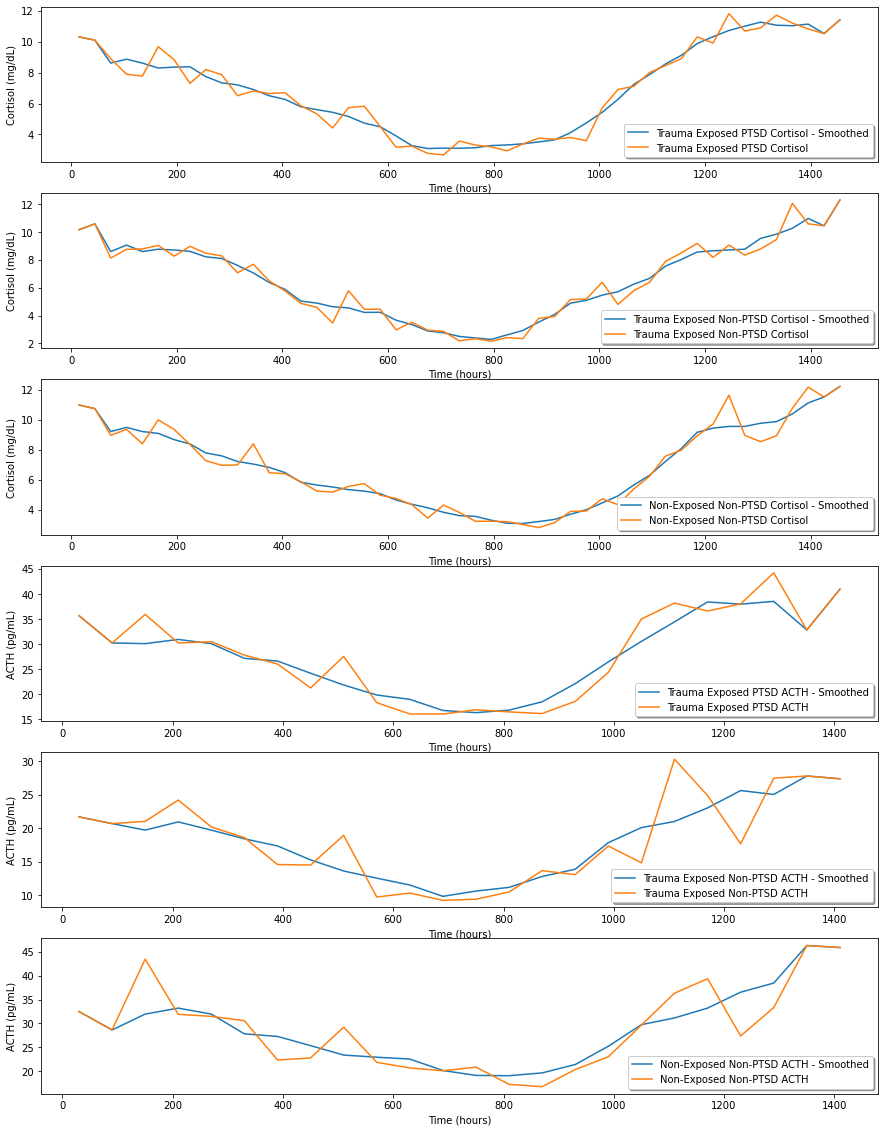

In [261]:
%matplotlib inline

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 6, figsize = (15,20))

ax1.plot(golierPTSDCortisol_rearr_smooth[:,0], golierPTSDCortisol_rearr_smooth[:,1], label = "Trauma Exposed PTSD Cortisol - Smoothed")
ax1.plot(golierPTSDCortisol_rearr[:,0], golierPTSDCortisol_rearr[:,1], label = "Trauma Exposed PTSD Cortisol")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (mg/dL)")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(golierNonPTSDTraumaExposedCortisol_rearr_smooth[:,0], golierNonPTSDTraumaExposedCortisol_rearr_smooth[:,1], label = "Trauma Exposed Non-PTSD Cortisol - Smoothed")
ax2.plot(golierNonPTSDTraumaExposedCortisol_rearr[:,0], golierNonPTSDTraumaExposedCortisol_rearr[:,1], label = "Trauma Exposed Non-PTSD Cortisol")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (mg/dL)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(golierNonPTSDNonExposedCortisol_rearr_smooth[:,0], golierNonPTSDNonExposedCortisol_rearr_smooth[:,1], label = "Non-Exposed Non-PTSD Cortisol - Smoothed")
ax3.plot(golierNonPTSDNonExposedCortisol_rearr[:,0], golierNonPTSDNonExposedCortisol_rearr[:,1], label = "Non-Exposed Non-PTSD Cortisol")
ax3.set(xlabel="Time (hours)", ylabel="Cortisol (mg/dL)")
ax3.legend(loc="lower right", shadow = True, fancybox = True)

ax4.plot(golierPTSDACTH_rearr_smooth[:,0], golierPTSDACTH_rearr_smooth[:,1], label = "Trauma Exposed PTSD ACTH - Smoothed")
ax4.plot(golierPTSDACTH_rearr[:,0], golierPTSDACTH_rearr[:,1], label = "Trauma Exposed PTSD ACTH")
ax4.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax4.legend(loc="lower right", shadow = True, fancybox = True)

ax5.plot(golierNonPTSDTraumaExposedACTH_rearr_smooth[:,0], golierNonPTSDTraumaExposedACTH_rearr_smooth[:,1], label = "Trauma Exposed Non-PTSD ACTH - Smoothed")
ax5.plot(golierNonPTSDTraumaExposedACTH_rearr[:,0], golierNonPTSDTraumaExposedACTH_rearr[:,1], label = "Trauma Exposed Non-PTSD ACTH")
ax5.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax5.legend(loc="lower right", shadow = True, fancybox = True)

ax6.plot(golierNonPTSDNonExposedACTH_rearr_smooth[:,0], golierNonPTSDNonExposedACTH_rearr_smooth[:,1], label = "Non-Exposed Non-PTSD ACTH - Smoothed")
ax6.plot(golierNonPTSDNonExposedACTH_rearr[:,0], golierNonPTSDNonExposedACTH_rearr[:,1], label = "Non-Exposed Non-PTSD ACTH")
ax6.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax6.legend(loc="lower right", shadow = True, fancybox = True)


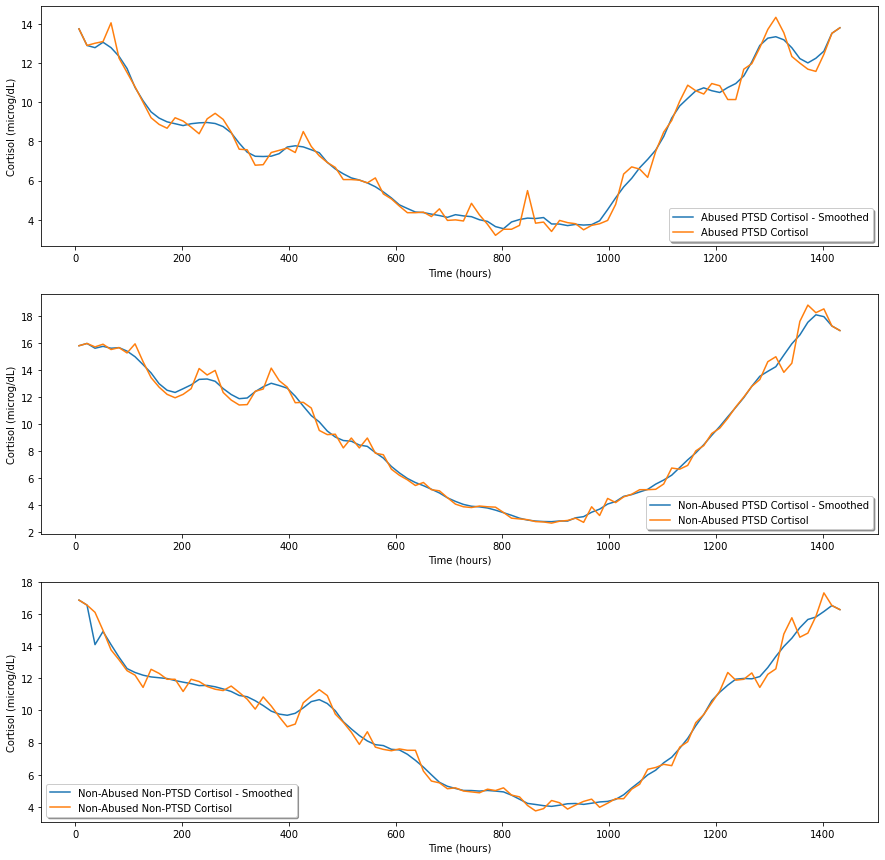

In [262]:
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (15,15))

ax1.plot(bremnerAbusedPTSDCortisol_rearr_smooth[:,0], bremnerAbusedPTSDCortisol_rearr_smooth[:,1], label = "Abused PTSD Cortisol - Smoothed")
ax1.plot(bremnerAbusedPTSDCortisol_rearr[:,0], bremnerAbusedPTSDCortisol_rearr[:,1], label = "Abused PTSD Cortisol")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (microg/dL)")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(bremnerNonAbusedPTSDCortisol_rearr_smooth[:,0], bremnerNonAbusedPTSDCortisol_rearr_smooth[:,1], label = "Non-Abused PTSD Cortisol - Smoothed")
ax2.plot(bremnerNonAbusedPTSDCortisol_rearr[:,0], bremnerNonAbusedPTSDCortisol_rearr[:,1], label = "Non-Abused PTSD Cortisol")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (microg/dL)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(bremnerNonAbusedNonPTSDCortisol_rearr_smooth[:,0], bremnerNonAbusedNonPTSDCortisol_rearr_smooth[:,1], label = "Non-Abused Non-PTSD Cortisol - Smoothed")
ax3.plot(bremnerNonAbusedNonPTSDCortisol_rearr[:,0], bremnerNonAbusedNonPTSDCortisol_rearr[:,1], label = "Non-Abused Non-PTSD Cortisol")
ax3.set(xlabel="Time (hours)", ylabel="Cortisol (microg/dL)")
ax3.legend(loc="lower left", shadow = True, fancybox = True)


## Model Function -- Includes ODE Solver

In [253]:
def model(params, ics, t):
    def ode_system(t, y):
        dy = np.zeros(5)
                
        [p_A, p_O, p_C, p_R, d_A, d_O, d_C, d_R, mu_R, K_A, K_R, T_C, T_d, I_base, C_bar, b, k, mu_C, q1, n] = params
        
        dy[0] = (C_inf(y[3]) - y[0])/T_C
        dy[1] = p_C*(I_base - I_ext(t))*h(y[0])*g_C(y[1]) - d_C*y[1]
        dy[2] = p_A*y[1]*(K_A/(K_A+y[3]*y[4])) - d_A*y[2]
        dy[3] = p_O*y[2]*(t-T_d) - d_O*y[3]
        dy[4] = p_R*(1 - (mu_R*(K_R**2))/(K_R**2 + (y[3]*y[4])**2)) - d_R*y[4]
        
        return dy
    
    def C_inf(O):
        return C_bar + np.exp(-b*O)
    
    def I_ext(t):
        # for now, we will just return 0, because I think this is like in the Best model, where we can
        #     use this function to test the behavior of the system in a stressed state, rather than resting.
        #     let's start with the resting state of no external synaptic input stimulating CRH release
        return 0
    
    def h(C_s):
        return (1 - np.exp(-k*C_s))
    
    def g_C(C):
        return (1 - mu_C/(1 + (q1*C)**n))
    
    # solve the system with scipy.integrate.ode to see if it's any faster
    solver = sci.ode(ode_system)
    solver.set_integrator('vode', method='bdf', nsteps = 1000000)
    solver.set_initial_value(ics, t_start)
    
    ts = []
    ys = []
    
    while solver.successful() and solver.t < t_end:
        solver.integrate(solver.t + t_step)
        ts.append(solver.t)
        ys.append(solver.y)
        
    # reshape the output frome ode to an array with the times on the first column
    ts = np.reshape(ts, (len(ts),1))
    ys = np.vstack(ys)
    timeSeries = np.hstack((ts, ys))
    return timeSeries

## Cost Function Definition

In [110]:
def cost_fun(params):
    # call the solve function
    simData = model(params, y0, timeLength)
    
    # this is where Rick makes sure we only have unique values for t, so no time step is repeated
    # I'll include it commented out here, and see if it changes anything later
    #idx = np.unique(simData[:,0], return_index = True)
    #idx = idx[1]
    #simData = simData[idx,:]
    
    # here, rick performs a cubic interpolation between time steps
    # I could either do this, or just compute the SSE between the raw data and computed data points without doing
    # the interpolation (as long as every raw data point is hit by the time steps the model computes)
    spline_ACTH = interp1d(simData[:,0], simData[:,2], kind = 'linear')
    spline_CORT = interp1d(simData[:,0], simData[:,3], kind = 'linear')
    
    # compute the actual cost value for the current parameter set by finding SSE between raw data and splines
    # this is where we change the data set we are trying to match, so that it computes the cost based on whatever
    #     data set we put in as the x values into the spline and the y values to subtract
    acthSSE = np.sum((spline_ACTH(carrollControlACTH_rearr_smooth[:,0]) - carrollControlACTH_rearr_smooth[:,1])**2)
    cortSSE = np.sum((spline_CORT(carrollControlCortisol_rearr_smooth[:,0]) - carrollControlCortisol_rearr_smooth[:,1])**2)
    
    # if i run it with acth data, also, can make cost the average of cortisol and ACTH SSEs
    cost = (acthSSE+cortSSE)/2
    # for now though, cost is just the SSE of cortisol data and simulation
    #cost = cortSSE
    
    return cost

## Run the Optimization

In [303]:
# number of times to run the optimization
n = 1

# define an array to hold the population of parameter vectors
opt_pars = np.zeros((n, len(bounds)+1))

# initialize arrays to save simulation cortisol and ACTH data from each optimization
sims_cort = np.zeros((2402, n))
sims_acth = np.zeros((2402, n))
sims_crh = np.zeros((2402, n))
sims_crh_s = np.zeros((2402, n))
sims_gr = np.zeros((2402, n))

In [309]:
%%time

# loop n times, running the optimization each time
for i in range(0,n):
    
    print(f"Optimization Run #{i+1}")
    
    # call the differential evolution optimization function on the cost function
    res = sco.differential_evolution(cost_fun, bounds, maxiter = 999, disp = True, popsize = 1)
    
    # alternatively, we can run the SHGO algorithm with the sampling_method = "sobol" flag to do global
    #     optimization with reporting all local minima, as well
    #res = sco.shgo(cost_fun, bounds, callback=callback_fun(*shgo_iter_steps), options = {"f_min": 0.1, "maxiter": None, "minimize_every_iter": True, "local_iter": False, "disp": True}, iters = 3)
    #res = sco.basinhopping(cost_fun, x0, niter = 1000)
    #res = sco.dual_annealing(cost_fun, bounds)
    
    # plug the optimized parameters into the solver
    optimizedSimData = model(res.x, y0, timeLength)
    
    # save CRH, cortisol and ACTH data into sims arrays
    sims_gr[:,i] = optimizedSimData[:,5]
    sims_cort[:,i] = optimizedSimData[:,4]
    sims_acth[:,i] = optimizedSimData[:,3]
    sims_crh[:,i] = optimizedSimData[:,2]
    sims_crh_s[:,i] = optimizedSimData[:,1]
    
    # save the cost function values and optimized parameters for each iteration into the array opt_pars
    opt_pars[i,0] = res.fun
    opt_pars[i,1:] = res.x

Optimization Run #1


/Users/christopher/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/Users/christopher/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


ValueError: A value in x_new is above the interpolation range.

## Save Output to File

## Compute Means and Std Devations of Parameters and Output as Table

## Plots

## No Optimization Run and Plot

In [299]:
pars = [p_A, p_O, p_C, p_R, d_A, d_O, d_C, d_R, mu_R, K_A, K_R, T_C, T_d, I_base, C_bar, b, k, mu_C, q1, n]

In [300]:
simData = model(pars, y0, timeLength)

In [301]:
print(simData)

[[ 5.66274997e-01  1.00298253e+00  1.54608235e+00  2.90015771e+05
  -2.08626321e+00  8.38820334e-01]]


## Load Parameter Sets from File and Generate Hormone Data